In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator
from matplotlib import cycler
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.offsetbox import AnchoredText
from scipy.optimize import curve_fit

# Matplotlib style template
## For black, set #000000. For navy, set #002060
defaultcolor = '#002060'
plt.rcParams.update({'text.color': defaultcolor, 'axes.labelcolor': defaultcolor, 
                     'xtick.color': defaultcolor, 'ytick.color': defaultcolor,
                     'axes.prop_cycle': cycler(color=['b', 'r', 'limegreen']),
                     'font.family':'serif', 'font.serif': 'Times New Roman',
                     'font.size': 22, 'lines.linewidth': 3,
                     'figure.figsize': (9.6, 5.4), 'figure.dpi': 100})

In [12]:
dirname = 'Runs/test/'
allcsv = pd.read_csv(dirname+'allflares.csv')
allcsv

,date,post_fit_start_time,post_fit_start_count,post_fit_peak_time,post_fit_peak_count,post_fit_end_time,post_fit_end_count,complex_region,active_region,multi_flare_region_flag,...,snr,fluence,pre_fit_start_time,pre_fit_start_count,pre_fit_peak_time,pre_fit_peak_count,pre_fit_end_time,pre_fit_end_count,flag,identifier
0,20221104,82785.0,9.56,82965.0,101.03,83655.0,13.85,1,False,False,...,134.37,4331.99,82735.0,15.64,82995.0,110.18,83655.0,3.83,True,20221104aq
1,20221104,8135.0,4.08,8455.0,42.79,8785.0,4.13,6,False,False,...,60.91,1789.12,7945.0,5.94,8475.0,54.19,9585.0,-18.31,True,20221104aa
2,20221104,80175.0,49.67,80575.0,507.60,82615.0,129.80,1,False,False,...,594.35,19913.89,79135.0,-14.67,80565.0,595.60,82615.0,86.22,True,20221104ap
3,20221104,72505.0,10.25,73475.0,103.02,75295.0,70.03,6,False,True,...,292.76,7879.08,71875.0,-2.70,73475.0,112.80,75295.0,57.44,True,20221104ao
4,20221104,71875.0,0.00,74915.0,20.66,75295.0,11.98,6,False,True,...,19.31,532.73,71875.0,-2.81,74965.0,49.90,75295.0,-0.61,True,20221104an
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8040,20190921,15395.0,0.32,15585.0,3.26,15975.0,0.33,20,False,False,...,49.34,95.15,14695.0,0.09,15555.0,4.35,17215.0,-0.27,True,20190921aa
8041,20190917,70935.0,0.90,71015.0,7.00,71215.0,0.69,15,False,False,...,38.79,94.35,69295.0,0.39,70995.0,7.71,71935.0,-0.28,True,20190917ab
8042,20190917,60615.0,0.25,60895.0,2.45,61415.0,0.25,12,False,False,...,58.77,99.95,60295.0,-0.26,60885.0,3.33,61735.0,0.56,True,20190917aa
8043,20190915,65555.0,0.14,66025.0,1.37,66505.0,0.14,18,False,False,...,36.05,71.73,64615.0,0.07,65895.0,3.96,67255.0,-0.29,True,20190915aa


In [13]:
cond1 = allcsv['fit_param_tau'] < 1e7       # No sigmoid like flares
cond2 = allcsv['flare amplitude'] / allcsv['pre_fit_peak_count'] < 100    # No spiky flares
cond3 = allcsv['post_fit_peak_count'] > 0
cond4 = ((allcsv['rsquared'] > 0.4) & (allcsv['post_fit_peak_count'] + allcsv['mean_background'] < 50)) | \
        ((allcsv['rsquared'] > 0.38) & (allcsv['post_fit_peak_count'] + allcsv['mean_background'] < 1000)) | \
        (allcsv['post_fit_peak_count'] + allcsv['mean_background'] >= 1000)
cond5 = allcsv['fit_param_Aprime'] > 0
cond6 = allcsv['post_fit_start_time'] < allcsv['post_fit_peak_time']      # Discard start of day flares
cond7 = allcsv['post_fit_peak_time'] < allcsv['post_fit_end_time']        # Discard end of day flares
cond8 = allcsv['snr'] > 8

cond_cuts = cond1 & cond2 & cond3 & cond4 & cond5 & cond6 & cond7 & cond8

In [14]:
keys = ['date', 'identifier', 'post_fit_start_time', 'post_fit_start_count', 'post_fit_peak_time', 'post_fit_peak_count', 
        'post_fit_end_time', 'post_fit_end_count', 'complex_region', 'multi_flare_region_flag', 'multi_flare_unresolved_flag',
        'flare_class_without_bg', 'mean_background', 'flare amplitude', 'fit_param_mu', 
        'fit_param_sigma', 'fit_param_tau', 'redchisq', 'rsquared', 'snr', 'fluence']
filtered_flares = allcsv[keys].copy()

# complex_region --> scpeaks0-05 (int) : number of peaks in flare duration with scipy.signal.find_peaks(prominence=0.05)
# Multi_flare_region_flag (bool) : is the flare decomposed from a multi flare region? True => Yes, False => No
# Multi_flare_unresolved_flag --> Multi_flare_resolved_flag : was region fully decomposed? True => Yes, False => No
# background is equivalent to c in EFP function
filtered_flares.columns = [
    'date', 'identifier', 'start_time', 'start_count', 'peak_time', 'peak_count', 'end_time', 'end_count', 
    'scpeaks0-05', 'multi_flare_region_flag', 'region_resolved_flag', 'flare_class', 'background', 
    'amplitude', 'mu', 'sigma', 'tau', 'redchisq', 'rsquared', 'snr', 'fluence'
]
filtered_flares

,date,identifier,start_time,start_count,peak_time,peak_count,end_time,end_count,scpeaks0-05,multi_flare_region_flag,...,flare_class,background,amplitude,mu,sigma,tau,redchisq,rsquared,snr,fluence
0,20221104,20221104aq,82785.0,9.56,82965.0,101.03,83655.0,13.85,1,False,...,B1,486.17,311.52,82874.65,61.21,329.99,106.529,0.883,134.37,4331.99
1,20221104,20221104aa,8135.0,4.08,8455.0,42.79,8785.0,4.13,6,False,...,A4,414.51,43.39,8435.23,147.99,25.00,199.630,0.571,60.91,1789.12
2,20221104,20221104ap,80175.0,49.67,80575.0,507.60,82615.0,129.80,1,False,...,B5,434.21,2114.62,80434.14,175.50,1230.74,761.981,0.952,594.35,19913.89
3,20221104,20221104ao,72505.0,10.25,73475.0,103.02,75295.0,70.03,6,True,...,B1,326.08,513.42,73015.00,364.05,3518.37,189.323,0.822,292.76,7879.08
4,20221104,20221104an,71875.0,0.00,74915.0,20.66,75295.0,11.98,6,True,...,A2,326.08,20.89,74863.92,357.32,54.72,189.323,0.248,19.31,532.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8040,20190921,20190921aa,15395.0,0.32,15585.0,3.26,15975.0,0.33,20,False,...,sub-A,0.77,5.65,15505.91,70.91,151.24,0.186,0.785,49.34,95.15
8041,20190917,20190917ab,70935.0,0.90,71015.0,7.00,71215.0,0.69,15,False,...,sub-A,0.86,13.86,70976.08,29.52,79.72,0.295,0.841,38.79,94.35
8042,20190917,20190917aa,60615.0,0.25,60895.0,2.45,61415.0,0.25,12,False,...,sub-A,0.57,3.76,60795.40,113.09,185.74,0.172,0.792,58.77,99.95
8043,20190915,20190915aa,65555.0,0.14,66025.0,1.37,66505.0,0.14,18,False,...,sub-A,0.86,1.39,65982.45,216.56,46.39,0.422,0.329,36.05,71.73


In [15]:
# Create new column "sigma-by-tau"
filtered_flares['sigma-by-tau'] = filtered_flares['sigma'] / filtered_flares['tau']

In [16]:
condfastrise = filtered_flares['sigma-by-tau'] < 2.65

# Create new column "flare_type" and assign value='O' by default
filtered_flares['flare_type'] = 'O'
# Overwrite flare_type value='A' for slow-rising flares
filtered_flares.loc[~cond_cuts, 'flare_type'] = 'F'     # False detection
filtered_flares.loc[cond_cuts & ~condfastrise, 'flare_type'] = 'A'
filtered_flares.loc[cond_cuts & condfastrise, 'flare_type'] = 'B'

# Create new column "duration" and assign "end_time - start_time"
filtered_flares['duration'] = filtered_flares['end_time'] - filtered_flares['start_time']

filtered_flares

,date,identifier,start_time,start_count,peak_time,peak_count,end_time,end_count,scpeaks0-05,multi_flare_region_flag,...,mu,sigma,tau,redchisq,rsquared,snr,fluence,sigma-by-tau,flare_type,duration
0,20221104,20221104aq,82785.0,9.56,82965.0,101.03,83655.0,13.85,1,False,...,82874.65,61.21,329.99,106.529,0.883,134.37,4331.99,0.185490,B,870.0
1,20221104,20221104aa,8135.0,4.08,8455.0,42.79,8785.0,4.13,6,False,...,8435.23,147.99,25.00,199.630,0.571,60.91,1789.12,5.919600,A,650.0
2,20221104,20221104ap,80175.0,49.67,80575.0,507.60,82615.0,129.80,1,False,...,80434.14,175.50,1230.74,761.981,0.952,594.35,19913.89,0.142597,B,2440.0
3,20221104,20221104ao,72505.0,10.25,73475.0,103.02,75295.0,70.03,6,True,...,73015.00,364.05,3518.37,189.323,0.822,292.76,7879.08,0.103471,B,2790.0
4,20221104,20221104an,71875.0,0.00,74915.0,20.66,75295.0,11.98,6,True,...,74863.92,357.32,54.72,189.323,0.248,19.31,532.73,6.529971,F,3420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8040,20190921,20190921aa,15395.0,0.32,15585.0,3.26,15975.0,0.33,20,False,...,15505.91,70.91,151.24,0.186,0.785,49.34,95.15,0.468857,B,580.0
8041,20190917,20190917ab,70935.0,0.90,71015.0,7.00,71215.0,0.69,15,False,...,70976.08,29.52,79.72,0.295,0.841,38.79,94.35,0.370296,B,280.0
8042,20190917,20190917aa,60615.0,0.25,60895.0,2.45,61415.0,0.25,12,False,...,60795.40,113.09,185.74,0.172,0.792,58.77,99.95,0.608862,B,800.0
8043,20190915,20190915aa,65555.0,0.14,66025.0,1.37,66505.0,0.14,18,False,...,65982.45,216.56,46.39,0.422,0.329,36.05,71.73,4.668247,F,950.0


In [17]:
filtered_flares.to_csv(dirname+'allflares_preprocessed.csv', index=False)

In [15]:
import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt
from scipy.special import erf

def EFP(time: np.int32 | npt.NDArray[np.int32], amplitude: np.float64, mu: np.float64, sigma: np.float64, tau: np.float64) -> np.float64 | npt.NDArray[np.float64]:
    Aprime = amplitude * sigma / (tau * np.sqrt(2 / np.pi))
    y1 = -(time - mu) / tau + sigma**2 / (2 * tau**2)
    y2 = (time - mu) / (np.sqrt(2) * sigma) - sigma / (np.sqrt(2) * tau)
    return Aprime * np.exp(y1) * (1 + erf(y2))

def plot_flare(identifier: str):
    dirname = 'Runs/paper/'
    datafile = f'{dirname}flares/{identifier}.csv'
    df = pd.read_csv(datafile)
    summaryfile = f'{dirname}allflares_preprocessed.csv'
    allcsv = pd.read_csv(summaryfile)
    row = allcsv[allcsv['identifier'] == identifier].iloc[0]

    fig, axs = plt.subplots(2, figsize=(9.6, 9.6), gridspec_kw={'height_ratios': [3, 1]})

    axs[0].set_title(f'{identifier}')
    plt.xlabel('Time (s)')
    plt.subplots_adjust(hspace=.0)
    linestyle = {"elinewidth":1, "capsize":0, "ecolor":"grey"}
    plt.setp(axs[0].get_xticklabels(), visible=False)

    xt = df['Time']
    yt = df['Counts']
    yerr = df['Error']

    axs[0].errorbar(xt, yt, yerr=yerr, fmt='D', ms=3, c='blue', **linestyle)

    for ax in axs:
        ax.tick_params(which='major', width=1)
        ax.tick_params(which='major', length=4)
        ax.margins(x=0)
    axs[0].set_ylabel('Flux (nW/m$^2$)')
    axs[1].set_ylabel('Residual ((o-f)/$\\sigma$)')
    axs[1].set_ylim(bottom=-4,top=4)

    range = (np.max(yt) - np.min(yt))/10
    axs[0].scatter(row['start_time'], \
        row['start_count'], c='k', s=30, zorder=15)
    axs[0].vlines(x=row['start_time'], \
        ymin=row['start_count'] - range, \
        ymax=row['end_count'] + range, color='k', linestyle='dotted', linewidth=2)
    axs[0].scatter(row['end_time'], \
        row['end_count'], c='k', s=30, zorder=15)
    axs[0].vlines(x=row['end_time'], \
        ymin=row['end_count'] - range, \
        ymax=row['end_count'] + range, color='k', linestyle='dotted', linewidth=2)

    yfit = EFP(xt, row['amplitude'], row['mu'], row['sigma'], row['tau'])
    axs[0].plot(xt, yfit, c='r', zorder=10, lw=3)
    axs[0].tick_params(axis='x', direction='in')
    axs[1].errorbar(xt, (yt-yfit)/np.std(yt-yfit), yerr=yerr/np.std(yt-yfit), fmt='D', ms=3, c='blue', **linestyle)
    axs[1].axhline(np.mean((yt-yfit)/np.std(yt-yfit)), linestyle='--', lw=1, c='navy')

    plt.show()

In [16]:
pwd

'/Users/penguin/Documents/Grad School/Research/XSM/XSM-Analysis-multiflarefit2/XSM-Analysis-multiflarefit2'

In [17]:
filtered_flares = pd.read_csv(f'Runs/paper/allflares_preprocessed.csv')

In [18]:
filtered_flares[filtered_flares['identifier'] == '20210301c']

,date,identifier,start_time,start_count,peak_time,peak_count,end_time,end_count,scpeaks0-05,multi_flare_region_flag,...,mu,sigma,tau,redchisq,rsquared,snr,fluence,sigma-by-tau,flare_type,duration
6665,20210301,20210301c,4005.0,12.32,4195.0,127.88,4445.0,12.62,1,False,...,4137.23,76.99,77.66,23.779,0.985,246.32,3027.61,0.991373,B,440.0


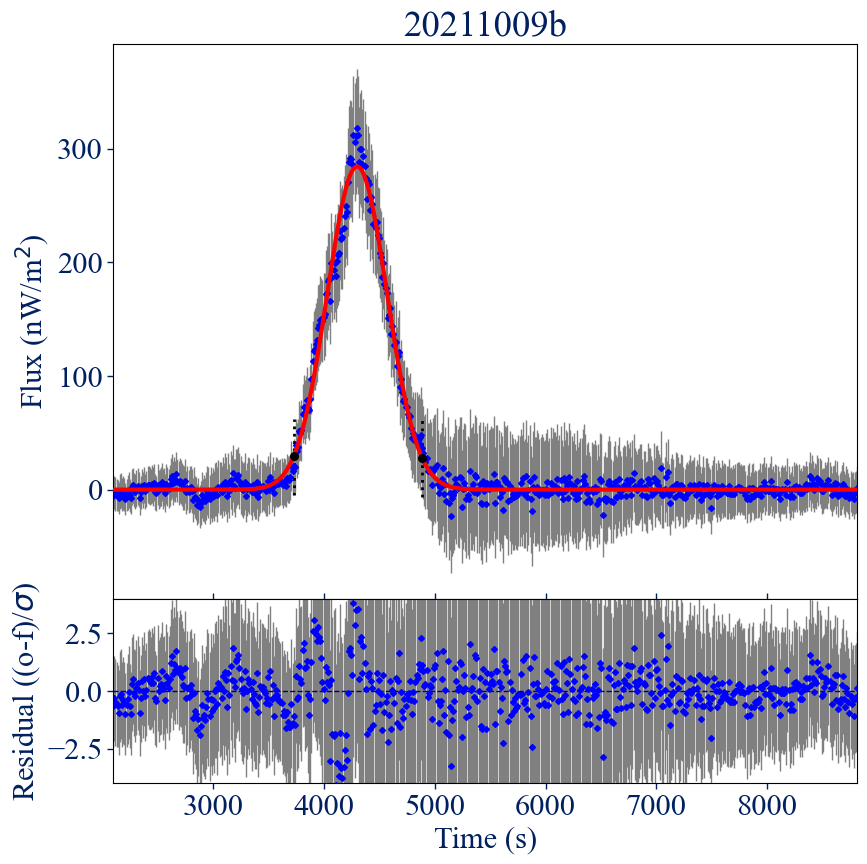

In [19]:
plot_flare('20211009b')